<a href="https://colab.research.google.com/github/Doclikam/Causal-inference-for-Treatment-Effects-in-Head-Neck-Radiotherapy./blob/main/RADCURE_causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RADCURE - CHEMOTHERAPY/RADIOTHERAPY HEAD AND NECK CANCER RESPONSE**

Assumptions

Positivity(overlap):  Every patient must have a non-zero probability of receiving either treatment option, given their baseline confounders.



  Age,sex,HPV, TNM staging, ECOG, path Smoking.            
  
          ↓        ↓
          ↓  Treatment (Chemo+RT vs RT)
          ↓       ↓
       ┌────────────┬────────────┐
       ↓            ↓            ↓
    OS Event     PFS Event    Recurrence

In [92]:
#main libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from datetime import datetime

# Display all columns
pd.set_option('display.max_columns', None)

In [117]:
from lifelines import KaplanMeierFitter

In [93]:
original_radcure_data = pd.read_excel("/content/RADCURE_Clinical_v04_20241219.xlsx")#load the excel file
original_radcure_data.head(2)#visulize the first 2 patients

,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,M,Stage,Path,HPV,Tx Modality,Chemo,RT Start,Dose,Fx,Last FU,Status,Length FU,Date of Death,Cause of Death,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,M0,IVB,Squamous Cell Carcinoma,"Yes, Negative",RT alone,none,2002-02-20,60.0,25,2003-05-12,Dead,1.317808,2003-05-12,Other Cause,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,M0,I,Squamous Cell Carcinoma,NaN,RT alone,none,2006-01-17,51.0,20,2007-06-28,Dead,1.520548,2007-06-28,Other Cause,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1


In [94]:
#standardize column names
original_radcure_data.columns = original_radcure_data.columns.str.strip().str.lower()

In [95]:
#Columns
original_radcure_data.columns

Index(['patient_id', 'age', 'sex', 'ecog ps', 'smoking py', 'smoking status',
       'ds site', 'subsite', 't', 'n', 'm', 'stage', 'path', 'hpv',
       'tx modality', 'chemo', 'rt start', 'dose', 'fx', 'last fu', 'status',
       'length fu', 'date of death', 'cause of death', 'local', 'date local',
       'regional', 'date regional', 'distant', 'date distant', '2nd ca',
       'date 2nd ca', 'radcure-challenge', 'contrastenhanced'],
      dtype='object')

In [96]:
#create a copy of the dataset
radcure_data= original_radcure_data.copy()

# Define Exposure (Treatment)

We limit to a **binary** clinical decision made at baseline:

- `ChemoRT`: Chemotherapy + Radiotherapy
- `RT-alone`: Radiotherapy alone

Patients receiving postoperative radiotherapy (n=3) or radiotherapy combined with EGFR inhibitors (n=72) were excluded from the primary causal contrast, as these regimens represent distinct treatment pathways with different biological mechanisms. The primary comparison was therefore between definitive radiotherapy alone and concurrent chemoradiation.

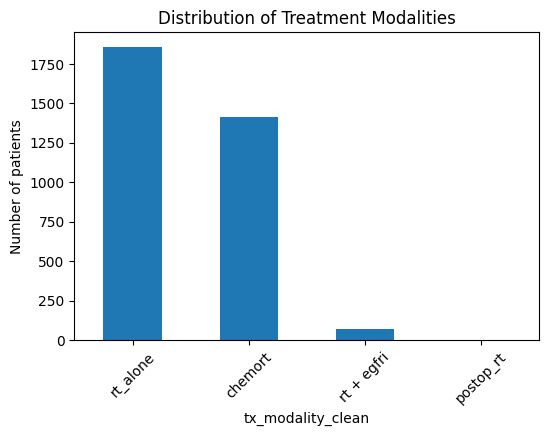

In [103]:
plt.figure(figsize=(6,4))
radcure_data['tx_modality_clean'].value_counts().plot(kind='bar')
plt.title("Distribution of Treatment Modalities")
plt.ylabel("Number of patients")
plt.xticks(rotation=45)
plt.show()

In [122]:
#create new column status otcome 1 : dead and  0: alive
radcure_data['status_outcome'] = (radcure_data['status'].str.lower() == 'dead').astype(int)
radcure_data["os_end"] = radcure_data["date of death"].fillna(radcure_data["last fu"])
radcure_data["time_os_days"] = (radcure_data["os_end"] - radcure_data["rt start"]).dt.days
mortality_table = radcure_data.groupby('tx_modality_clean')['status_outcome'].agg(
    patients='count',
    deceased='sum'
)

In [123]:
#compute numeric mortality rate
mortality_table['mortality_rate'] = (
    mortality_table['deceased'] / mortality_table['patients']
)
mortality_table

,patients,deceased,mortality_rate
tx_modality_clean,,,
chemort,1413,318,0.225053
postop_rt,3,2,0.666667
rt + egfri,72,35,0.486111
rt_alone,1858,703,0.378364


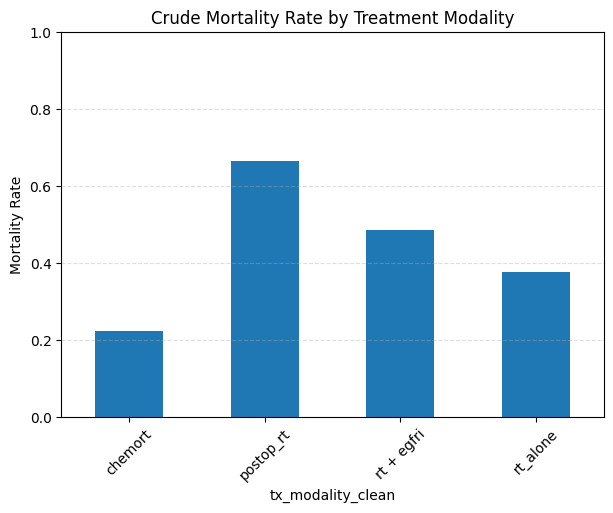

In [115]:
#bar graph visual
mortality_table['mortality_rate'].plot(kind='bar', figsize=(7,5))
plt.title("Crude Mortality Rate by Treatment Modality")
plt.ylabel("Mortality Rate")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

**Treatment Modality Distribution and Justification for Removing RT + EGFRI**:
Patients treated with RT + EGFR inhibitors (N=75) were excluded from the primary causal analysis. This subgroup is typically selected based on inability to tolerate chemotherapy or specific tumor biology (e.g., HPV+ OPC), resulting in structural differences in baseline prognosis. Inclusion would violate the positivity assumption, as these patients had near-zero probabilities of receiving either RT-alone or ChemoRT given their clinical characteristics.

**Kaplan–Meier curves of overall surviva**l

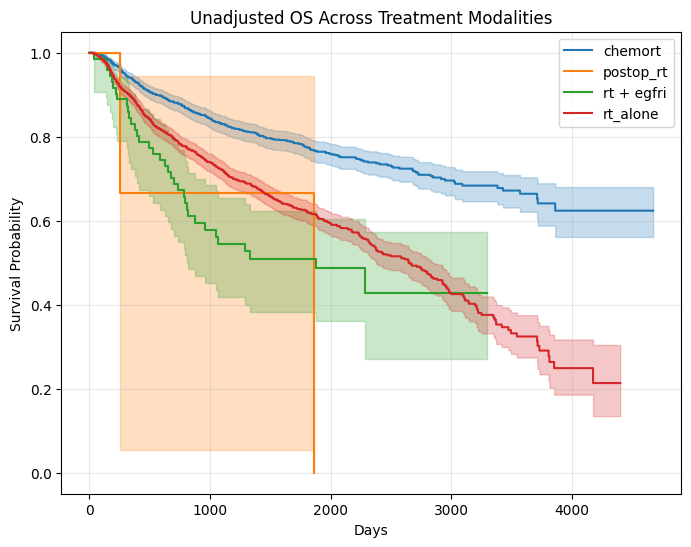

In [128]:
km = KaplanMeierFitter()
plt.figure(figsize=(8,6))
for tx, grp in radcure_data.groupby('tx_modality_clean'):
  km.fit(grp['time_os_days'], grp['status_outcome'], label=tx)
  km.plot()
plt.title("Unadjusted OS Across Treatment Modalities")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)
plt.savefig('Treatment Modalities')
plt.show()

Unadjusted Kaplan–Meier curves demonstrated clear heterogeneity in crude survival across modalities. Patient on ChemoRT appear a better crude survival outcome, followed by radiotherapy alone. However, this is unadjusted, hence these  difference mixes true treatment effect + selection differences(depending on variables like age, TNM, ECOG ).

Radio+EGFRI have very wide Confidence intervals with few patients and worse prognosis. These patients are likely to be  more sick more chemo-ineligible. The very early drop and broad bands is typical whehn we plot small,high-risk subgroup with KM, unadjusted KM is not evidence of causal benefit/harm. EGFRI shows near-zero overlap with RT-alone/ChemoRT in baseline risk.st-op RT represents a different treatment strategy (surgery+RT), not the baseline policy of interest.

In [97]:
#harmonize the treatment modality from 'RT alone', 'ChemoRT', 'RT + EGFRI', 'ChemoRT ', 'Postop RT alone'
radcure_data["tx_modality"] = radcure_data["tx modality"].str.lower().str.strip()

radcure_data['tx_modality_clean'] = radcure_data['tx_modality'].replace({
    'rt alone': 'rt_alone',
    'chemort': 'chemort',
    'rt + e gfri': 'rt_egfri',  # ensure mapping correct
    'postop rt alone': 'postop_rt'
})

#check unique treatment modalities
print("\nUnique treatment modalities (cleaned):")
print(radcure_data['tx_modality_clean'].value_counts(dropna=False))

#Our treatment (Radiotherapy alone vs Radiotherapy +chemotherapy)
#Primary causal exposure: chemo(addon) vs RT only
rad_data= radcure_data[
    radcure_data['tx_modality_clean'].isin(['rt_alone','chemort'])
].copy()
rad_data['treatment'] = (rad_data['tx_modality_clean'] == 'chemort').astype(int)

print("\n Treatment: ( 0= Radiation alone, 1=Chemoradiation)")
print(rad_data['treatment'].value_counts())



Unique treatment modalities (cleaned):
tx_modality_clean
rt_alone      1858
chemort       1413
rt + egfri      72
postop_rt        3
Name: count, dtype: int64

 Treatment: ( 0= Radiation alone, 1=Chemoradiation)
treatment
0    1858
1    1413
Name: count, dtype: int64


 # Downstream treatment components

This include RT dose, dose per fraction, number of fractions, treatment duration, and calculated(BED/EQD2). This are not pre-treatment characteristics they are part of the treatment itself.Adjusting for dose/fractions would remove part of the treatment’s real effect by blocking part of the causal pathway.

## Survival Outcomes


Overall Survival: Time from start of radiotherapy (rt_start) to death from any cause.

If the patient is alive, the last follow-up date (last_fu) is used : censored observation.


- Time zero = **RT Start**
- Event = **death from any cause**
- Censoring = Last follow-up if alive
- All times in **days**
-Progression-Free Survival (PFS)- Time from radiotherapy start until first recurrence or death, whichever occurs first.

Recurrence = local, regional, or distant failure.

Composite endpoints (local/regional/distant recurrence, PFS) are built without removing patients lacking event dates.

We need to enure that there is no patient with:
 Missing RT start = invalid time zero.

Missing last follow-up = no censoring point.

Negative or zero OS time = impossible timeline.

Death after follow-up = temporal inconsistency.

In [98]:
#rename event cols
event_cols = ['rt start', 'last fu','length fu', 'date of death', 'cause of death', 'local',
             'date local', 'regional', 'date regional', 'distant',
             'date distant', '2nd ca', 'date 2nd ca']

# build mapping only for columns that exist in rad_data
rename_map = {
    c: c.strip().lower().replace(" ", "_").replace("-", "_")
    for c in event_cols if c in rad_data.columns
}

rad_data.rename(columns=rename_map, inplace=True)


In [99]:
rad_data.columns

Index(['patient_id', 'age', 'sex', 'ecog ps', 'smoking py', 'smoking status',
       'ds site', 'subsite', 't', 'n', 'm', 'stage', 'path', 'hpv',
       'tx modality', 'chemo', 'rt_start', 'dose', 'fx', 'last_fu', 'status',
       'length_fu', 'date_of_death', 'cause_of_death', 'local', 'date_local',
       'regional', 'date_regional', 'distant', 'date_distant', '2nd_ca',
       'date_2nd_ca', 'radcure-challenge', 'contrastenhanced', 'tx_modality',
       'tx_modality_clean', 'treatment'],
      dtype='object')

In [100]:
#Only date columns to parse (true dates only)
date_cols = [
    "rt_start", "last_fu", "date_of_death",
    "date_local", "date_regional", "date_distant", "date_2nd_ca"
]
print("\nParsed date columns overview:")
print(rad_data[date_cols].dtypes)

for c in date_cols:
    if c in rad_data.columns:
        # set column to dates errors='coerce' -> NaT if unparseable
        rad_data[c] = pd.to_datetime(rad_data[c], errors="coerce")

# Overall survival (OS)
rad_data["os_end"] = rad_data["date_of_death"].fillna(rad_data["last_fu"])
rad_data["time_os_days"] = (rad_data["os_end"] - rad_data["rt_start"]).dt.days
rad_data["event_os"] = rad_data["date_of_death"].notna().astype(int)

# Exclude patients who died before they received RT
exclude_pre_rt_death = (
    rad_data['event_os'].eq(1) &
    (rad_data['date_of_death'] <= rad_data['rt_start'])
)

print("Excluding patients:", exclude_pre_rt_death.sum())

print()

# QC flags (do not drop — only flag)
rad_data["bad_time_zero"]  = rad_data["rt_start"].isna().astype(int)
rad_data["bad_followup"]   = rad_data["last_fu"].isna().astype(int)
rad_data["neg_or_zero_os"] = (
    rad_data["time_os_days"].isna() | (rad_data["time_os_days"] <= 0)
).astype(int)
rad_data["death_after_fu"] = (
    rad_data["event_os"].eq(1) & (rad_data["date_of_death"] > rad_data["last_fu"])
).astype(int)

print("\n--- QC Summary ---")
print(rad_data[["bad_time_zero", "bad_followup", "neg_or_zero_os", "death_after_fu"]].sum())
print(f"\nTotal patients flagged for any QC issue: {(rad_data[['bad_time_zero', 'bad_followup', 'neg_or_zero_os', 'death_after_fu']].sum(axis=1) > 0).sum()}")

# Event flags from the start of treatment: 1 if that event occurred, 0 otherwise
for site in ["local", "regional", "distant", "2nd_ca"]:
    date_col = f"date_{site}"
    if date_col in rad_data.columns:
        rad_data[f"event_{site}"] = rad_data[date_col].notna().astype(int)
    else:
        rad_data[f"event_{site}"] = 0

# Time-to-event (only for rows with that event) from treatment start
#If event didn’t occur: leave as NaN (censored)
for site in ["local", "regional", "distant"]:
    date_col = f"date_{site}"
    if date_col in rad_data.columns:
        rad_data[f"time_{site}_days"] = np.where(
            rad_data[f"event_{site}"] == 1,
            (rad_data[date_col] - rad_data["rt_start"]).dt.days,
            np.nan
        )
# print event counts
print("Event counts (any recurrence):")
print(rad_data[["event_local","event_regional","event_distant","event_2nd_ca"]].sum())



# Progression-Free Survival (first of any recurrence OR death)
#time_pfs_days: Time from RT start to earliest progression or death
#event_pfs: 1 = progression/death, 0 = censored
pfs_sources = [c for c in ["date_local","date_regional","date_distant","date_of_death"] if c in rad_data.columns]
if pfs_sources:
    pfs_end = pd.concat([rad_data[c] for c in pfs_sources], axis=1).min(axis=1)
    rad_data["time_pfs_days"] = (pfs_end - rad_data["rt_start"]).dt.days
    rad_data["event_pfs"] = (
        (rad_data[["event_local","event_regional","event_distant"]].sum(axis=1) > 0) |
        (rad_data["event_os"] == 1)
    ).astype(int)
    # Censor PFS at last FU if no event
    rad_data.loc[rad_data["event_pfs"] == 0, "time_pfs_days"] = (
        rad_data["last_fu"] - rad_data["rt_start"]
    ).dt.days
print(f"PFS computed for {rad_data['time_pfs_days'].notna().sum()} patients.")
print(f"Median Progress Free Survival (PFS) (days): {rad_data['time_pfs_days'].median():.0f}")



# Follow-up (descriptive)
rad_data["followup_days"] = (rad_data["last_fu"] - rad_data["rt_start"]).dt.days

#set non-positive times to NaN (keep flagged via QC vars above)
for col in ["time_os_days","time_pfs_days","time_local_days","time_regional_days","time_distant_days","followup_days"]:
    if col in rad_data.columns:
        rad_data.loc[rad_data[col] <= 0, col] = np.nan


Parsed date columns overview:
rt_start         datetime64[ns]
last_fu          datetime64[ns]
date_of_death    datetime64[ns]
date_local       datetime64[ns]
date_regional    datetime64[ns]
date_distant     datetime64[ns]
date_2nd_ca      datetime64[ns]
dtype: object
Excluding patients: 0


--- QC Summary ---
bad_time_zero     0
bad_followup      0
neg_or_zero_os    0
death_after_fu    0
dtype: int64

Total patients flagged for any QC issue: 0
Event counts (any recurrence):
event_local       368
event_regional    184
event_distant     403
event_2nd_ca      428
dtype: int64
PFS computed for 3271 patients.
Median Progress Free Survival (PFS) (days): 1145


In [101]:
print("Total before selection:", 3346)
print("Total after selection:", len(rad_data))

print("\nDeceased before:", 1058)
print("Deceased after:", rad_data['event_os'].sum())

Total before selection: 3346
Total after selection: 3271

Deceased before: 1058
Deceased after: 1021


For radiotherapy+EGFR their mortality is much higher than typical ChemoRT or RT-only. Hence there is :
 -Severe case mix difference
 -No overlap → cannot be weighted to comparability

# **Confounder processing**

###Smoking — baseline behavioral risk factor

Both pack-years and status influence:
- treatment choice (Chemo vs RT)
- survival


                 

In [69]:
rad_data['smoking status'].value_counts()

,count
smoking status,
Ex-smoker,1254
Current,1121
Non-smoker,851
unknown,45


In [70]:
#Smoking status
rad_data['smoking_status_clean'] = (
    rad_data['smoking status'].astype(str).str.strip().str.title()
)
print("\n Smoking status categories (cleaned):")
print(rad_data['smoking_status_clean'].value_counts(dropna=False))

#We have "na" values in our dataset that are not accounted for in the missingnes and inconsistencies such as >5, <20
# clean smoking pack-year column
rad_data["smoking_py_clean"] = (
    rad_data["smoking py"]
    .astype(str)
    .str.strip()
    .replace({"na": np.nan, "NA": np.nan, "NaN": np.nan, "": np.nan})
)

# Clean pack years strings
def clean_smoking_py(value):
    if pd.isna(value): return np.nan
    v = str(value).strip().lower()

    if v.startswith("<"):
        try: return float(v[1:]) / 2
        except: return np.nan

    if v.startswith(">"):
        try: return min(float(v[1:]) + 5, 120)
        except: return np.nan

    try:
        return float(v)
    except:
        return np.nan

rad_data['smoking_py_clean'] = rad_data['smoking py'].apply(clean_smoking_py)

# Inconsistency flags
rad_data['smoking_mismatch_flag'] = (
    ((rad_data['smoking_status_clean'] == 'Non-Smoker') &
     (rad_data['smoking_py_clean'] > 0)) |
    ((rad_data['smoking_status_clean'].isin(['Ex-Smoker','Current'])) &
     (rad_data['smoking_py_clean'].isna() | (rad_data['smoking_py_clean'] == 0)))
).astype(int)
print("\n Inconsistencies detected and flagged:")
print(rad_data['smoking_mismatch_flag'].value_counts())

# Correct inconsistencies
rad_data.loc[
    (rad_data['smoking_status_clean'] == 'Non-Smoker') &
    (rad_data['smoking_py_clean'] > 0),
    'smoking_py_clean'
] = 0 #if person is a non-smoker and has values other than 0 replace with 0

rad_data.loc[
    (rad_data['smoking_status_clean'].isin(['Ex-Smoker','Current'])) &
    (rad_data['smoking_py_clean'] == 0),
    'smoking_py_clean'
] = np.nan #if person has smoked/currenty smoking and has 0 pack years replace with np.nan

# Missingness indicator
rad_data['smoking_py_missing'] = rad_data['smoking_py_clean'].isna().astype(int)
print("🚭 Missing pack-years after cleaning:", rad_data['smoking_py_missing'].sum())
print("-" * 60)


print("\n combined view (sample of 5):")
print(
    rad_data[['smoking status', 'smoking_status_clean',
               'smoking py', 'smoking_py_clean',
               'smoking_mismatch_flag']].sample(5, random_state=42))


 Smoking status categories (cleaned):
smoking_status_clean
Ex-Smoker     1254
Current       1121
Non-Smoker     851
Unknown         45
Name: count, dtype: int64

 Inconsistencies detected and flagged:
smoking_mismatch_flag
0    3261
1      10
Name: count, dtype: int64
🚭 Missing pack-years after cleaning: 55
------------------------------------------------------------

 combined view (sample of 5):
     smoking status smoking_status_clean smoking py  smoking_py_clean  \
1666     Non-smoker           Non-Smoker          0               0.0   
135      Non-smoker           Non-Smoker          0               0.0   
422      Non-smoker           Non-Smoker          0               0.0   
205       Ex-smoker            Ex-Smoker          2               2.0   
1178      Ex-smoker            Ex-Smoker          1               1.0   

      smoking_mismatch_flag  
1666                      0  
135                       0  
422                       0  
205                       0  
1178     

 ### Disease Site And Subsite

 Mapped into **4 clinically meaningful groups**:
- Oropharynx
- Larynx
- Nasopharynx
- Other_HNC

Subsite included **only** for Oro/Larynx where relevant and complete

In [71]:
rad_data['ds site'].value_counts()

,count
ds site,
Oropharynx,1453
Larynx,867
Nasopharynx,355
Unknown,167
Hypopharynx,154
Lip & Oral Cavity,95
nasal cavity,34
Paranasal Sinus,27
Nasal Cavity,27


In [72]:
#lower case for consistent naming of the tumor sites.
rad_data['ds_site'] = rad_data['ds site'].astype(str).str.lower().str.strip()

# map for consistent naming of the DS site
primary_site_map = {
    'nasal cavity': 'nasal cavity',
    'nasal cavity ': 'nasal cavity',
    'esophagus': 'esophagus',
    'lip & oral cavity': 'lip_oral_cavity'
}
rad_data['ds_site_clean'] = rad_data['ds_site'].replace(primary_site_map)

#for casual modelling we will use four main groups.
def primary_group(site):
    if 'oropharynx' in site:
        return "Oropharynx"
    if 'larynx' in site:
        return "Larynx"
    if 'nasopharynx' in site:
        return "Nasopharynx"
    return "Other_HNC"

#apply this changes
rad_data['primary_site_group'] = rad_data['ds_site_clean'].apply(primary_group)

print("Sample of cleaned site names:")
print(rad_data['ds_site_clean'].value_counts().head(5))
print("\nPrimary site grouping distribution:")
print(rad_data['primary_site_group'].value_counts())

Sample of cleaned site names:
ds_site_clean
oropharynx     1453
larynx          867
nasopharynx     355
unknown         167
hypopharynx     154
Name: count, dtype: int64

Primary site grouping distribution:
primary_site_group
Oropharynx     1453
Larynx          867
Other_HNC       596
Nasopharynx     355
Name: count, dtype: int64


In [73]:
#handle the missingness of subsite
rad_data['subsite_clean'] = rad_data['subsite'].astype(str).str.strip().str.title()


# we subsite that are flagged as valid; clinically relevant & low missingness
flagged_subsite_sites = ["Oropharynx", "Larynx"]
rad_data.loc[
    ~rad_data['primary_site_group'].isin(flagged_subsite_sites),
    'subsite_clean'
] = np.nan  # Remove meaningless subsites

# Subsite missingness indicator only within valid groups to identify true missingness rather than structural
rad_data['subsite_missing'] = (
    rad_data['subsite_clean'].isna() &
    rad_data['primary_site_group'].isin(flagged_subsite_sites)
).astype(int)

print(
    rad_data.groupby('primary_site_group')['subsite_missing']
    .agg(['sum', 'count'])
    .assign(pct_missing=lambda x: 100 * x['sum'] / x['count'])
    .round(1)
    .sort_values('pct_missing', ascending=False)
)

print("\nTotal missing subsites (within valid sites):", rad_data['subsite_missing'].sum())

                    sum  count  pct_missing
primary_site_group                         
Larynx                0    867          0.0
Nasopharynx           0    355          0.0
Oropharynx            0   1453          0.0
Other_HNC             0    596          0.0

Total missing subsites (within valid sites): 0


# Path

The variable path include histological tumor subtypes. These affect  both treatment choice and prognosis

Grouping the confounders : SCC , NPC / Other epithelial,  Other rare; grouping protects positivity.

In [74]:
rad_data['path'].value_counts()

,count
path,
Squamous Cell Carcinoma,2773
NPC: Type 3 (WHO IIB),283
"NPC, Type 2 (WHO IIA)",60
Squamous Cell Carcinoma In-Situ,46
Adenoid Cystic,14
"NPC, Type 1 (WHO I)",11
Neuroendocrine ca (small cell),10
Adenosquamous Cell,8
Paraganglioma,7


In [75]:
def map_pathology(x: str):
    if pd.isna(x):
        return "Other_rare"
    s = str(x).strip().lower()

    # SCC tumors(catch common variants & case variants)
    if ("squamous" in s) or ("scc" in s) or ("verrucous" in s) or ("in-situ" in s):
        return "SCC"

    # NPC tumors (WHO I–III / type 1–3)
    if ("npc" in s) or ("nasopharyngeal" in s) or ("who ii" in s) or ("who i" in s) or ("who iii" in s):
        return "NPC"

    # Other epithelial (salivary/adenocarcinoma family, adenoid cystic, adenosquamous, basaloid, clear cell)
    if any(k in s for k in [
        "adenoid cystic", "adenocystic", "adeno", "salivary duct",
        "basaloid", "clear cell", "microcystic adnexal", "sebaceous"
    ]):
        return "Other_epithelial"

    # Other tumors: sarcomas, melanoma, snuc, nut midline, merkel, plasmacytoma, undiff, neuroendocrine)
    return "Other_rare"

#map this new classes
rad_data['pathology_group'] = rad_data['path'].apply(map_pathology)
#Check distribution of new groups
print("\nPathology group counts:")
print(rad_data['pathology_group'].value_counts(dropna=False))


Pathology group counts:
pathology_group
SCC                 2832
NPC                  354
Other_rare            59
Other_epithelial      26
Name: count, dtype: int64


### Tumor Extent at Diagnosis (TNM and Stage)

TNM missingness is **informative**.
We:
- preserve missing values
- add missingness flags
- distinguish **structural** vs **statistical** missing

In [76]:
#Flag non-TNM cancers (TNM not applicable)
def identify_non_tnm(site):
    site = str(site).lower()
    if any(x in site for x in ['paraganglioma', 'glomus', 'benign', 'orbit', 'lacrimal']):
        return 1
    return 0

rad_data['is_non_tnm'] = rad_data['ds_site_clean'].apply(identify_non_tnm)

#Flag structural TNM missing
# TNM exists but often not assessed in practice for these sites
rad_data['tnm_structural_missing'] = (
    rad_data['is_non_tnm'] |
    rad_data['ds_site_clean'].str.contains('skin|sarcoma|esophagus', case=False)
).astype(int)

#Remove TNM where not applicable (STRUCTURAL missing)
tnm_cols = ['t', 'n', 'm']
for col in tnm_cols:
    rad_data.loc[rad_data['tnm_structural_missing'] == 1, col] = np.nan

#Missingness flags for TNM (STATISTICAL missing)

for col in tnm_cols:
    rad_data[f'{col}_missing'] = (
        rad_data[col].isna() &
        (rad_data['tnm_structural_missing'] == 0)
    ).astype(int)

print("\n[Check 2] Structural TNM missing flag:")
print(rad_data['tnm_structural_missing'].value_counts(dropna=False))
print(f"→ {rad_data['tnm_structural_missing'].sum()} rows (structural TNM missing)")



#flag stage missing
rad_data['stage_missing'] = rad_data['stage'].isna().astype(int)
print("\nStage missingness rate:")
print(f"→ {100 * rad_data['stage_missing'].mean():.1f}% of records missing stage info")


[Check 2] Structural TNM missing flag:
tnm_structural_missing
0    3185
1      86
Name: count, dtype: int64
→ 86 rows (structural TNM missing)

Stage missingness rate:
→ 0.8% of records missing stage info


###HPV Status

HPV is only clinically relevant in **Oropharynx** tumors.

We recode:
- HPV_Positive
- HPV_Negative
- HPV_Unknown

HPV set to **NaN** outside Oropharynx to avoid spurious adjustment.

In [77]:
rad_data['hpv'].value_counts()

,count
hpv,
"Yes, positive",1104
"Yes, Negative",558


In [78]:
#Normalize the HPV entries to"HPV_positive","HPV_negative" or HPV_unknown
def clean_hpv(value):
    if pd.isna(value):
        return "HPV_Unknown"

    v = str(value).strip().lower()

    if "pos" in v:
        return "HPV_Positive"
    if "neg" in v:
        return "HPV_Negative"

    return "HPV_Unknown"

rad_data['hpv_clean'] = rad_data['hpv'].apply(clean_hpv)
print("\n[Check 1] HPV Cleaned Value Distribution:")
print(rad_data['hpv_clean'].value_counts(dropna=False))


# HPV specific/ relevant tumors ONLY in Oropharynx
rad_data['hpv_specific_tumors'] = (
    rad_data['primary_site_group'].eq("Oropharynx")
).astype(int)


# If HPV not relevant → set to NaN (avoid incorrect confounding)
rad_data.loc[
    rad_data['hpv_specific_tumors'] == 0,
    'hpv_clean'
] = np.nan

# Missingness flag: only meaningful for relevant cancers
rad_data['hpv_missing'] = (
    rad_data['hpv_clean'].isna() &
    rad_data['hpv_specific_tumors'].eq(1)
).astype(int)
print("\nHPV missingness (within relevant tumors):")
print(f"→ {rad_data['hpv_missing'].sum()} missing HPV entries among relevant cancers")



[Check 1] HPV Cleaned Value Distribution:
hpv_clean
HPV_Unknown     1609
HPV_Positive    1104
HPV_Negative     558
Name: count, dtype: int64

HPV missingness (within relevant tumors):
→ 0 missing HPV entries among relevant cancers


# ECOG

In [79]:
# ECOG
rad_data['ecog ps'].value_counts()

,count
ecog ps,
ECOG 0,1984
ECOG 1,1000
ECOG 2,205
ECOG 3,40
Unknown,31
ECOG 4,6
ECOG-Pt 2,1
ECOG 0-1,1
ECOG-Pt 0,1


In [80]:
#ECOG performance status
def clean_ecog(value):
    if pd.isna(value): return np.nan
    v = str(value).lower().strip()

    # Handle unknowns
    if 'unknown' in v:
        return np.nan

    # Extract number (handles formats: "ecog 1", "ecog-pt 1", etc.)
    match = re.search(r'(\d)', v)
    if match:
        return int(match.group(1))

    return np.nan  # fallback

rad_data['ecog_ps'] = rad_data['ecog ps'].apply(clean_ecog)

# ECOG missingness flag
rad_data['ecog_ps_missing'] = rad_data['ecog_ps'].isna().astype(int)


# **Final modelling Columns**

In [81]:
# List of columns to keep in analytic set
analytic_columns = [
    'patient_id',
    'treatment',
    'time_os_days','event_os',
    'time_pfs_days','event_pfs','time_pfs_days','event_pfs',
    'age','sex',
    'ecog_ps','ecog_ps_missing',
    'smoking_status_clean','smoking_py_clean','smoking_py_missing','smoking_mismatch_flag',
    'primary_site_group',
    'subsite_clean','subsite_missing',
    't','n','m','stage',
    't_missing','n_missing','m_missing','stage_missing',
    'hpv_clean','hpv_missing','hpv_specific_tumors',
    'pathology_group',
    'is_non_tnm','tnm_structural_missing',
    'followup_days'
]

# analytic set
rad_data_analysis = rad_data[analytic_columns].copy()
rad_data_analysis.to_csv("rad_data_analysis.csv", index=False)
print("Analytic dataset created:", rad_data_analysis.shape)


Analytic dataset created: (3271, 34)


In [82]:

confounder_model_columns = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group',
    't', 'n', 'm',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors']


rad_data_modelling = rad_data[confounder_model_columns].copy()
rad_data_modelling.to_csv("rad_data_modelling.csv", index=False)
print("confounder dataset created imported to csv:", rad_data_modelling.shape)


confounder dataset created imported to csv: (3271, 18)
